## EE512 – Applied Biomedical Signal Processing
# Practical session – Linear Models II
### Instructions
* This notebook provides all the questions of the practical session and the space to answer them. We recommend working directly here and then exporting the document as your report.
* Include any code used when addressing the questions, together with your answers.
* Please submit your report as a single PDF file.
* We recommend working in a group of 4–5 students; you must prepare one single report for the group (`name1_name2_name3_name4_name5_lab_LinearModelsII.pdf`), but every member needs to upload the same file individually.

In [3]:
%matplotlib widget

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import resample, welch, correlate
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
# File paths
fhr1 = os.path.join(os.getcwd(), 'data', 'heart_1.dat')
fhr2 = os.path.join(os.getcwd(), 'data', 'heart_2.dat')
fem1 = os.path.join(os.getcwd(), 'data', 'emg1.dat')
fem2 = os.path.join(os.getcwd(), 'data', 'emg2.dat')
fppg = os.path.join(os.getcwd(), 'data', 'ppg.dat')
feeg = os.path.join(os.getcwd(), 'data', 'eeg_stim.dat')

### Experiment 1: parametric spectral estimation of cardiorespiratory signals
The file `/data/heart_1.dat` contains three physiological signals: RR-interval, arterial pressure and respiration, in this order (sampled at 4 Hz). The recordings were made in a patient at rest. In the spectral domain, this RR-interval signal is expected to show a peak around 0.08 Hz, corresponding to the *baroreflex* (regulation between arterial blood pressure and heart rate), and a peak at 0.225 Hz, corresponding to the *breathing rate* (heart rhythm modulation by respiration, the so-called *“sinus arrhythmia”*) – see `/data/readme_heart.txt` for more details.

We start by importing the signals, subsampling to 1 Hz, and removing their averages:

In [5]:
with open(fhr1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr1 = np.array([float(s[0]) for s in txt])
    bp1 = np.array([float(s[1]) for s in txt])
    rs1 = np.array([float(s[2]) for s in txt])

df = 4
rr1 = resample(rr1, int(len(rr1)/df))
bp1 = resample(bp1, int(len(bp1)/df))
rs1 = resample(rs1, int(len(rs1)/df))

for y in [rr1, bp1, rs1]:
    y -= np.mean(y)

AR modeling provides tools for extracting various useful estimates from a signal, in a so-called *parametric* way, because the estimates are based on the model parameters, rather than on the raw signal itself. The function defined below implements the estimation of the signal spectral density based on its AR parameters.

In [8]:
def ar_psd(arg1, arg2, arg3, n=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        arg1: ?
        arg2: ?
        arg3: ?
        n: defines the spectral sampling
    
    Outputs:
        arg4: ?
        arg5: ?
    """
    
    arg5 = np.arange(n) * arg3/2/n
    aar, sg = yule_walker(arg1, order=arg2, method="mle")
    
    a = complex(1)
    for k in range(1,arg2+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*arg5/arg3)
    
    arg4 = sg**2 / (arg3 * np.abs(a)**2)
    
    return arg4, arg5

**Question 1.1.** The implementation above has an incomplete docstring (help text), and the input and output arguments have generic names (`arg1-5`). Copy the function to the answer space below, complete the help, and replace the argument names by more intuitive choices, based on what you've learned in the theory.

**Answer 1.1.** 
````python
def ar_psd(signal, order, fs, n=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        signal: an array of the signal
        order: order of the autoregressive process as an int
        fs: sampling frequency as a float
        n: defines the spectral sampling
    
    Outputs:
        psd: power spectral density as an array-like
        freq : array-like of frequencies 
    """
    
    freq = np.arange(n) * fs/2/n
    aar, sg = yule_walker(signal, order=order, method="mle")
    
    a = complex(1)
    for k in range(1,order+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*freq/fs)
    
    psd = sg**2 / (fs * np.abs(a)**2)
    
    return psd, freq

#### We now use this tool to obtain the spectral density of the three signals. Below, we explore the results obtained with different AR model orders: 5, 15, 40.

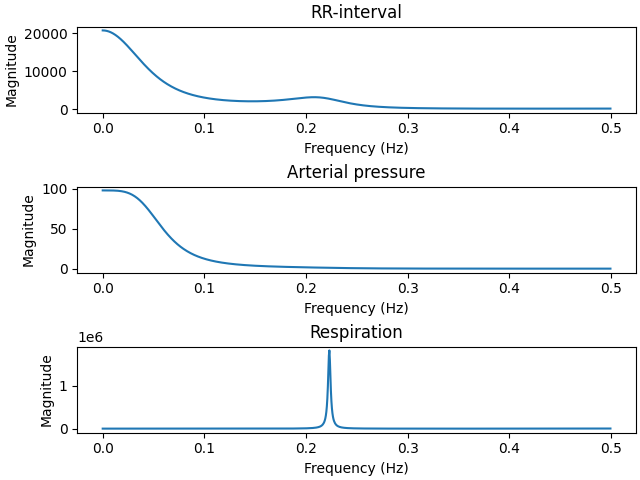

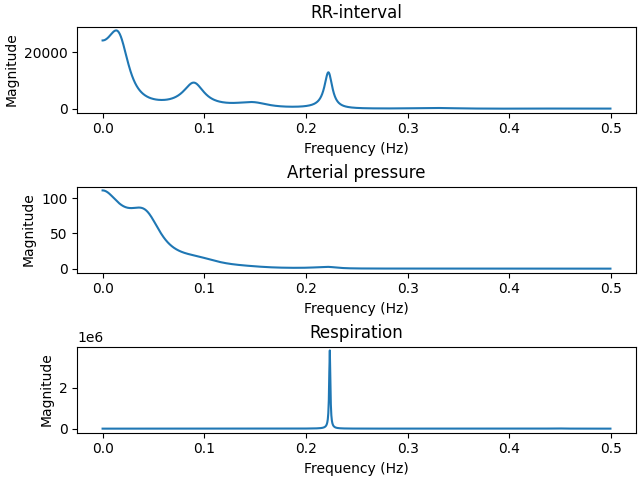

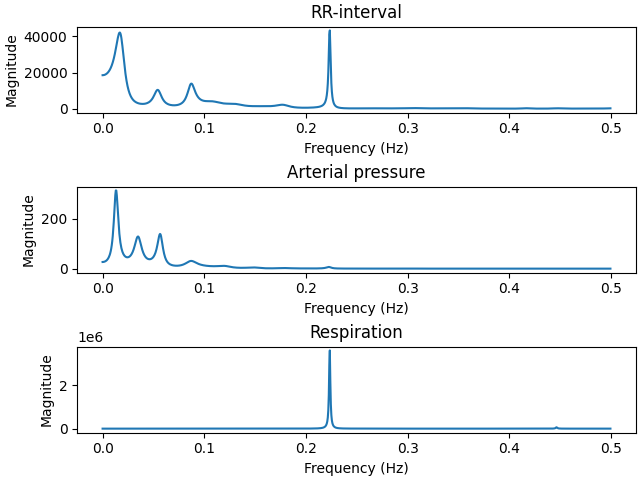

In [13]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

for p in (5, 15, 40):
    
    plt.figure(constrained_layout=True)
    
    for k in range(3):
        
        py, f = ar_psd(y[k], p, 1.0)
        
        plt.subplot(3,1,k+1)
        plt.plot(f, py)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(ttl[k])

**Question 1.2.** How does the order affect the spectra? Given the physiological description of the expected peaks for the RR-interval, what is the most suitable order choice?

**Answer 1.2.** We can see in general that by increasing the order, the spetra become less straight but more complex. In particular, for the respiration, the bigger the order, the narrower the interval of the peak is. In terms of the atrial pressure, with the raising of the order, we see an augmentation of the number of peaks. 

For the RR-interval, this interval is impacted by the respiration so we see a correlation between the two graphs with a peak at the same frequency (0.225). However, with the raising of the order, more peaks are not related to the physiological effect that we are looking. For the last order, we see peaks that are not necessary which will impact the atrial pressure and hide possible interpretation. Therefore, the most suitable order choice is of 15 as we see the two interesting peaks. 

We can now perform a *non-parametric* spectral estimation of the same signals, using for instance Welch’s method:

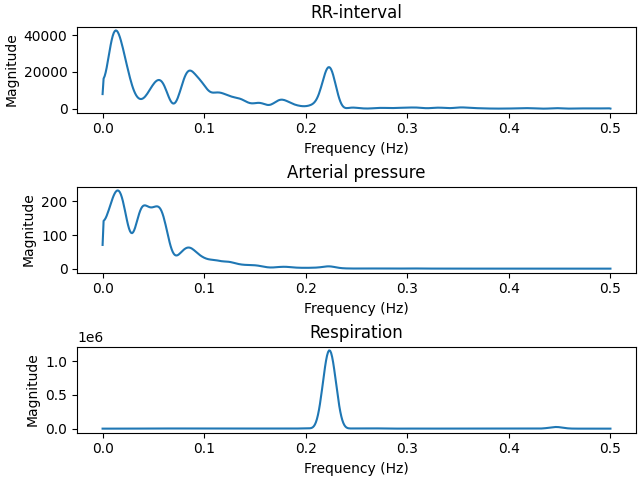

In [18]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

plt.figure(constrained_layout=True)

for k in range(3):
    
    f, py = welch(y[k], fs=1.0, nperseg=100, scaling='density', nfft=1000)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])

**Question 1.3.** Explain how Welch's method works (it may be helpful to consult the help of `welch`), and the fundamental differences between this approach and the AR parametric method.

**Answer 1.3.** 
The Welch's method works by performing a division of the data into overlapping segments, which will compute a modified periodogram for each segment and averaging them. The fundamental differences are that AR parametric method is auto-regressive (each point calculated depends on previous ones) and Welch model reduces noise only by averaging different results between them.

**Question 1.4.** In our particular problem, how do the spectra obtained with Welch's method compare with those of the parametric approach (order 15)? Given the previous RR-interval description, which approach performs most reliably?

**Answer 1.4.** 
In our particular problem, more oscillations are present with the Welch method. Also, the magnitude of the RR-interval and artial pressure approximately double. The width of the peaks is also bigger. 

In general, the non-parametric approach gives more complex plot. Therefore, more peaks are present. We can not say precisely which approach is more reliable. But the parametric approach follows more the expectations for the previous RR-interval description.

We now consider the signals in `/data/heart_2.dat`, which are recordings from the same individual after alcohol consumption.

In [25]:
with open(fhr2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr2 = np.array([float(s[0]) for s in txt])
    bp2 = np.array([float(s[1]) for s in txt])
    rs2 = np.array([float(s[2]) for s in txt])

**Question 1.5.** Repeat the processing steps done for `heart_1.dat` to obtain a parametric spectral estimation (order 15). Which of the physiological mechanisms described for the RR-interval was most disrupted by alcohol? And what other changes do you observe in the physiological signals?

**Answer 1.5.**  The most disrupted mechanism is the baroreflex. We can see the disrupted mechanism in the almost disappearance of the peak at 0.08Hz. Also, this results in a decrease on the amplitude of the 0.225 frequency signal in the RR-interval whereas a peak in the atrial pressure appears. This is the result of a inability of the the autonomic system to compensate the thoracic pressure differences by controling heart rate. The last thing is that the atrial pressure becomes depend


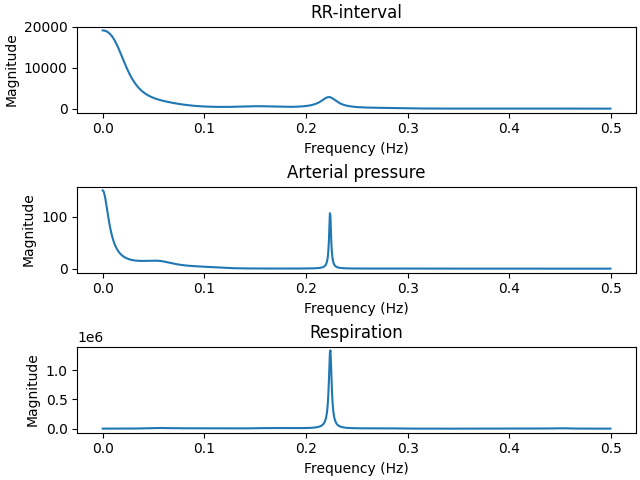

In [29]:
with open(fhr2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr2 = np.array([float(s[0]) for s in txt])
    bp2 = np.array([float(s[1]) for s in txt])
    rs2 = np.array([float(s[2]) for s in txt])

df = 4
rr2 = resample(rr2, int(len(rr2)/df))
bp2 = resample(bp2, int(len(bp2)/df))
rs2 = resample(rs2, int(len(rs2)/df))

for y in [rr2, bp2, rs2]:
    y -= np.mean(y)

y = [rr2, bp2, rs2]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

plt.figure(constrained_layout=True)
    
for k in range(3):
        
    py, f = ar_psd(y[k], 15, 1.0)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])

### Experiment 2: estimating the effects of fatigue on muscle signals
The files `/data/emg1.dat` and `/data/emg2.dat` contain three surface electromyography (sEMG) signals each (1024 Hz sampling frequency). These signals were recorded from the thigh muscle during a 10-min exercise on an ergocycle, respectively from an athlete (`emg1`) and from a moderately trained subject (`emg2`). In each file, the columns correspond to recordings from the *start*, *middle* and *end* of the exercise, respectively.

We start by importing the signals:

In [32]:
with open(fem1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em1 = np.zeros((n,3))
    for k in range(3):
        em1[:,k] = [float(s[k]) for s in txt]

with open(fem2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em2 = np.zeros((n,3))
    for k in range(3):
        em2[:,k] = [float(s[k]) for s in txt]

fs = 1024.0 # Hz

We first plot the sEMG segments in the time domain. We can observe four bursts in each recording, which correspond to four pedal strokes. The goal of the experiment was to assess the effects of fatigue on the signal properties of the sEMG.

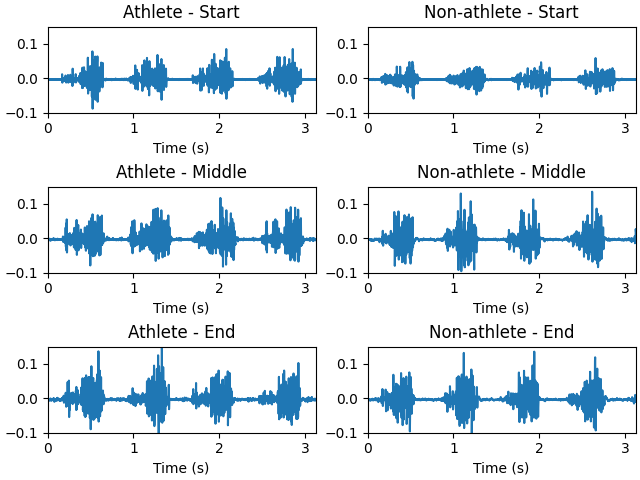

In [35]:
ttl1 = ['Athlete', 'Non-athlete']
ttl2 = ['Start', 'Middle', 'End']
t = np.arange(n) / fs

plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    
    for l in range(3):
        
        plt.subplot(3,2,2*l+k+1)
        plt.plot(t,y[:,l])
        plt.xlim(t[0], t[-1])
        plt.ylim(-0.10, 0.15)
        plt.xlabel('Time (s)')
        plt.title(ttl1[k] + ' - ' + ttl2[l])

We'll now look at the spectral profile of the signals. Considering, for instance, the start sEMG recording of the athlete, we obtain the parametric power spectral density (PSD) for an AR model of order 30:

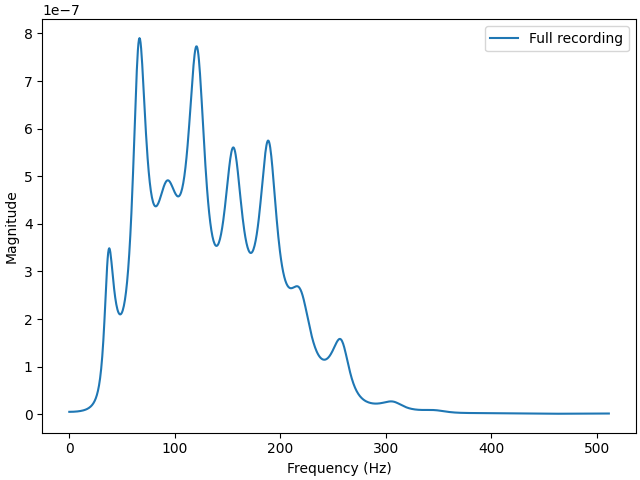

In [38]:
p = 30
pya_full, fa_full = ar_psd(em1[:,0], p, fs)

plt.figure(constrained_layout=True)
plt.plot(fa_full, pya_full, label='Full recording')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

**Question 2.1.** In principle, it would be more correct to segment each burst and analyze it separately, but it turns out that using the entire recording will yield a relatively similar spectral profile. Check that it is the case: copy the plotting code above to the space below and add (overlayed in the same panel) the PSD obtained from the first burst only, for the same signal. How do their profiles compare? Where does the difference in peak signal-to-noise come from?

**Answer 2.1.** 
As it can be seen below, by superposing the overall signal with the different burst one can observe that the main peaks of the 2 techniques have a similar profile, with the exception of the 2nd burst that seems to be a bit more different on comparison to the rest od the samples. Thus, the signal-to-noise is smaller with this technique since it averages the frequencies power over the all signal and decreases the eventual noisy frequencies that might appear in one burst recording. However it is important ot note that the magnitude of the power is much weaker in the overall signal. This is explained due to the silent parts in between of the bursts of the overall signal that decrease the power since the psd is taken as an estimation over the given time window.



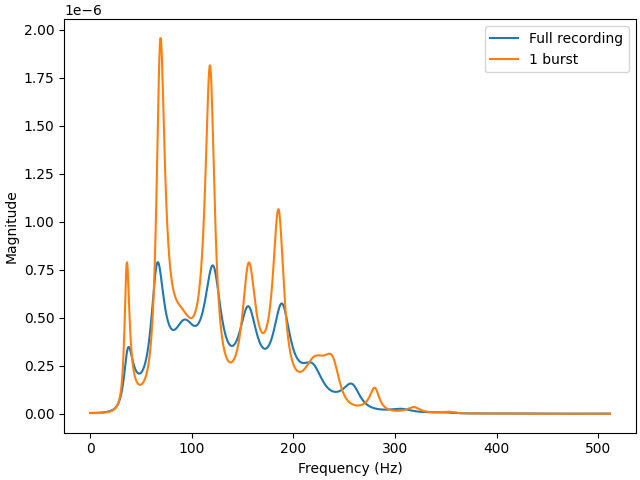

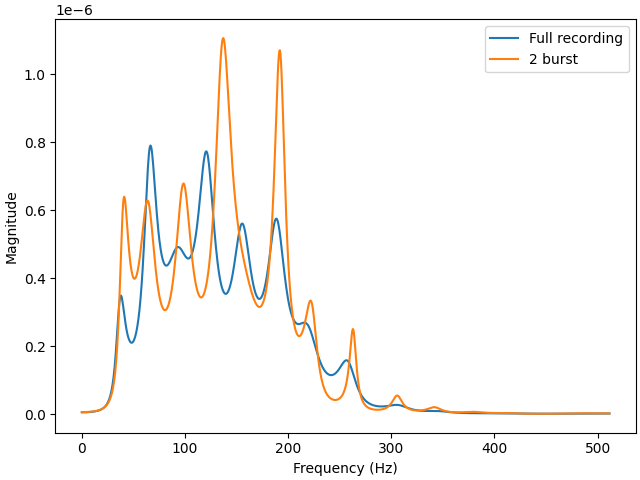

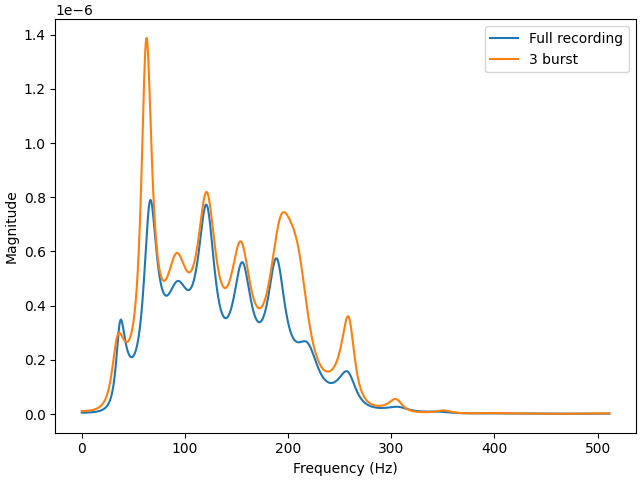

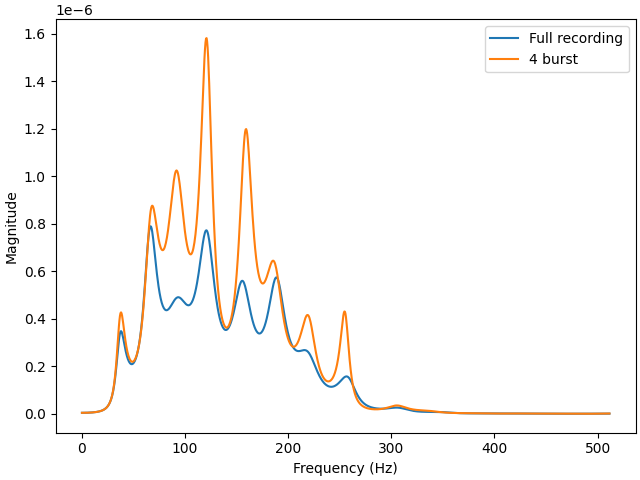

In [40]:
inds=[[ np.min(np.where((t>=i) & (t<=j))),  np.max(np.where((t>=i) & (t<=j)))] for i, j in [[0.118,0.7],[0.863,1.434],[1.63,2.23],[2.39,3.01]]]


for i, ind in enumerate(inds):
    plt.figure(constrained_layout=True)
    plt.plot(fa_full, pya_full, label='Full recording')
    pya, fa = ar_psd(em1[ind[0]:ind[1],0], p, fs)
    plt.plot(fa, pya, label= str(i+1) + ' burst')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()    

We now estimate and plot the PSD for every recorded segment of both individuals:

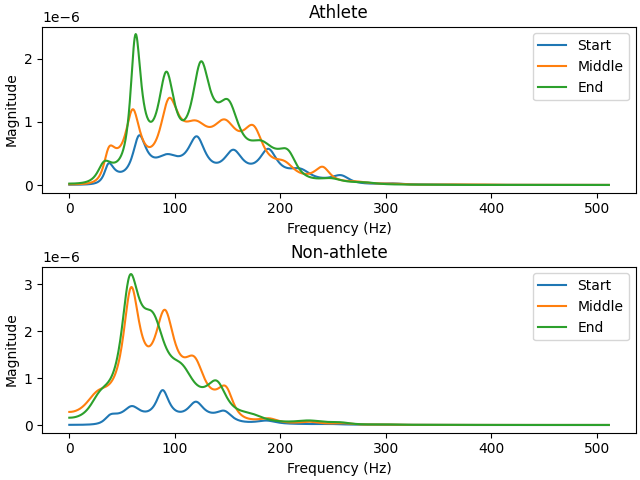

In [43]:
plt.figure(constrained_layout=True)
pyas=np.zeros((2,3)).tolist()
fas=np.zeros((2,3)).tolist()


for k in range(2):
    
    y = [em1, em2][k]
    plt.subplot(2,1,k+1)
    
    for l in range(3):
        
        pya, fa = ar_psd(y[:,l], p, fs)
        plt.plot(fa, pya, label=ttl2[l])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        
        pyas[k][l]=pya
        fas[k][l]=fa
    plt.title(ttl1[k])
    plt.legend()

**Question 2.2.** To complement the above PSD's, estimate the mean frequency using `sum(fa * pya / sum(pya))`. What does this formula express?

**Answer 2.2.** This formula expresses the mean frequency as a weighted average of all possible frequencies, where the weighting is derived from the frequency power. The normalization by the sum of the power is done such that the sum of the weights is 1.

In [47]:
data=[]
for j, recording in enumerate(ttl2):
    fm=[]
    for i,patient in enumerate(ttl1):
       fm.append(np.sum(fas[i][j]*pyas[i][j]/np.sum(pyas[i][j])))
    data.append([recording, *fm])
print('Mean frequencies:')
display(pd.DataFrame(data,columns=[ "Recording", *ttl1]).set_index('Recording'))


Mean frequencies:


,Athlete,Non-athlete
Recording,,
Start,136.507388,106.295477
Middle,127.307365,87.906964
End,121.096116,87.613740


**Question 2.3.** Based on the PSD plots and the mean frequencies obtained above, what marks the difference between the athlete and the moderately trained subject?

**Answer 2.3.**  It can be observed from the mean frequencies that the athlete is able to maintain higher frequencies for a longer time than the non-athlete. This can also be seen in the plots. Even though the overall sEMG power of the athlete's signal seems to be lower in amplitude than that of the non-athlete, we can see a constant presence of high frequencies even at the end of the athlete's recording, which is not the case for the non-athlete.

### Experiment 3: assessment of PPG signal structure
Photoplethysmography (PPG) is a simple, low-cost, non-invasive optical monitoring technique that can be used to detect volumetric changes in blood in the peripheral circulation, by measuring on the skin surface. It can be integrated in wearable devices (e.g. a watch) to monitor a person’s heart rate throughout daily life, and detect potential issues like atrial fibrillation. The file `/data/ppg.dat` contains a PPG recording from a normal cardiac rhythm, and another from a subject in atrial fibrillation (both sampled at 21.3 Hz).

We start by importing and plotting the two signals:

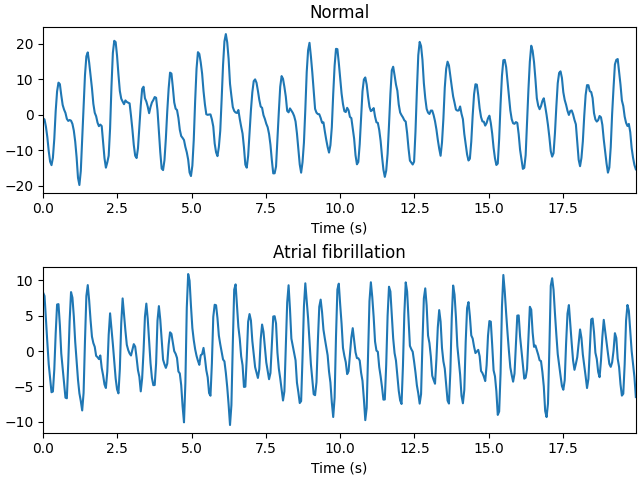

In [52]:
with open(fppg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    ppg1 = np.array([float(s[0]) for s in txt])
    ppg2 = np.array([float(s[1]) for s in txt])

for y in [ppg1, ppg2]:
    y -= np.mean(y)

fs = 21.3 # Hz

plt.figure(constrained_layout=True)
ttl = ['Normal', 'Atrial fibrillation']

n = len(ppg1)
t = np.arange(n) / fs

for k in range(2):
    
    y = [ppg1, ppg2][k]
    
    plt.subplot(2,1,k+1)
    plt.plot(t, y)
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

Each observed oscillation on the PPG typically corresponds to one pulse, generated by one cardiac cycle. By inspecting the plot above, we can already appreciate how one signal is visibly less regular than the other. AR modeling allows us to quantify the underlying differences with several complementary metrics.

We define again the function `ar_order` introduced in the previous practical session:

In [55]:
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)

    if Aff == 1:
        plt.figure()
        plt.plot(range(1, omax+1), c, 'o-')
        plt.title('Criterion')
        plt.show()
        
    return np.argmin(c)+1, s, c

**Question 3.1.** Estimate the optimal AR model order for each signal, using the function `ar_order` above (you can set a maximal order of 40 for the search).

**Answer 3.1.** `Write your answer here`

**Question 3.2.** Estimate the ratio between the excitation variance and the signal variance, for each signal (as in previous exercises, you can rely on the `yule_walker` function with `method='mle'`)

**Answer 3.2.** `Write your answer here`

**Question 3.3.** Estimate and plot the PSD of each signal, using the `ar_psd` function for the estimates (for consistency, use the same order of 20 for both signals)

**Answer 3.3.** `Write your answer here`

**Question 3.4.** Estimate the entropy of the PSD of each signal, using:

*p = py / sum(py)*

*entropy = sum(-p * log(p))*

where py is the vector of PSD amplitudes.

**Answer 3.4.** `Write your answer here`

**Question 3.5.** What do these measures (model order, variance ratio, PSD, entropy) tell us about the two signals? Interpret what you have obtained in terms of signal structure/organization.

**Answer 3.5.** `Write your answer here`

### Experiment 4: Pisarenko harmonic estimation of brain signals
The file `/data/eeg_stim.dat` contains three recordings of scalp electroencephalography (EEG; left frontal electrode, 4-s duration, 512 Hz sampling frequency) from a Parkinson's patient. The patient was also implanted with a deep brain stimulation (DBS) electrode. The first recording corresponds to a baseline (rest) state, the second was obtained during 1-Hz stimulation, and the third during 100-Hz stimulation.

We start by importing and plotting the three signals:

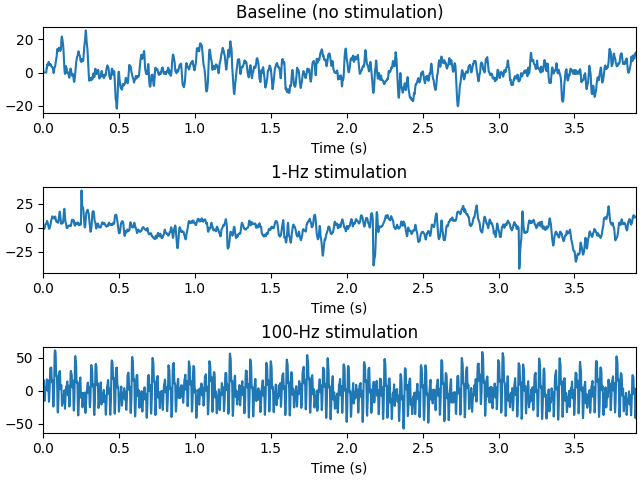

In [68]:
with open(feeg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    eeg = np.zeros((n,3))
    for k in range(3):
        eeg[:,k] = [float(s[k]) for s in txt]

fs = 512.0 # Hz

plt.figure(constrained_layout=True)
ttl = ['Baseline (no stimulation)', '1-Hz stimulation', '100-Hz stimulation']

t = np.arange(n) / fs

for k in range(3):
    plt.subplot(3,1,k+1)
    plt.plot(t, eeg[:,k])
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

**Question 4.1.** Visually, does any of the stimulation strategies appear to have an effect on the EEG? Which one(s)?

**Answer 4.1.**  Just by looking at the plots we can see that 100-hz stimulation is the one whit most effect oin the EEG.

As in previous examples, we can apply modeling techniques to quantify the physiological effects under study. Because the DBS is applied in a periodic regime with a specific frequency, it is reasonable to expect a strong sinusoidal presence on the EEG recordings, for any cases where the stimulation does produce a measurable effect. This motivates applying the Pisarenko harmonic retrieval approach, which is implemented below:

In [73]:
def pisarenko(x, p, fs, Aff=0):
    """
    Pisarenko method for harmonic retrieval
    
    x: signal
    p: number of sinusoids
    fs: sampling frequency
    Aff: 0 no graphic display; 1 display
    
    f: vector of sinusoid frequencies
    pp: vector of sinusoid amplitudes
    sg2: noise variance
    
    """
    
    n = len(x)
    
    rx = correlate(x, x, mode='full', method='auto') / n
    
    rxx = np.zeros((2*p+1,2*p+1))
    for k1 in range(2*p+1):
        for k2 in range(2*p+1):
            rxx[k1,k2] = rx[n-1 + abs(k1 - k2)]
    
    u, v = np.linalg.eig(rxx)
    
    sg2 = np.min(u)
    vm = v[:,np.argmin(u)]  # get eigenvector from smallest eigenvalue
    
    r = np.roots(vm)  # find roots of the polynomial
    f = np.angle(r) / (2*np.pi)  # get angle and convert to Hz/sample
    f = f[f > 0]
    
    # Amplitude estimation
    aa = np.zeros((p, len(f)))
    for k in range(p):
        aa[k,:] = np.cos(2*np.pi * (k+1) * f)
    
    r = rx[n:n+p]
    
    pp = np.linalg.lstsq(aa, r, rcond=None)[0]
    f *= fs
    
    if Aff:
        
        plt.figure(constrained_layout=True)
        
        plt.subplot(2,1,1)
        plt.plot(np.arange(1,n+1) / fs, x)
        plt.xlabel('Time (s)')
        plt.title('Signal')
        
        plt.subplot(2,1,2)
        plt.plot([0, fs/2], [sg2, sg2], linewidth=2)
        for k in range(p):
            plt.plot([f[k], f[k]], [sg2, sg2+pp[k]], linewidth=2)
        plt.axis([0, fs/2, 0, 1.2 * (np.max(pp) + sg2)])
        plt.xlabel('Frequency (Hz)')
        plt.title('Pisarenko spectrum')
    
    return f, pp, sg2

**Question 4.2.** Using the above function, apply the Pisarenko method with 5 sinusoids to each of the three recordings, and report the estimated parameters (frequencies, amplitudes, excitation variance).

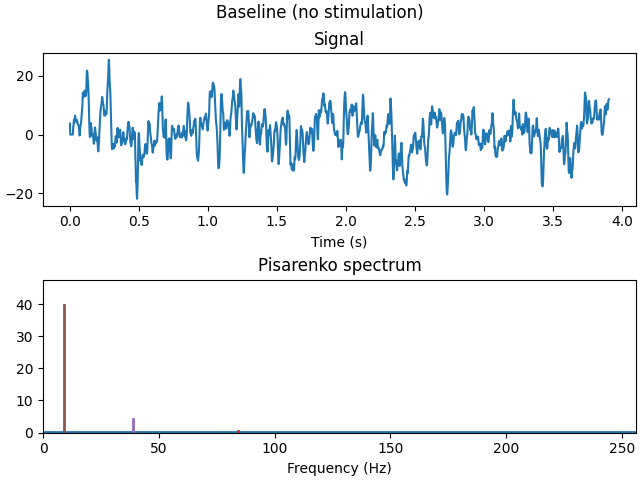

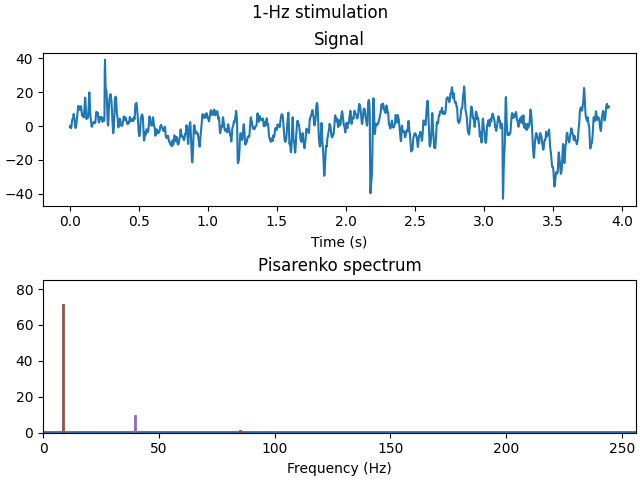

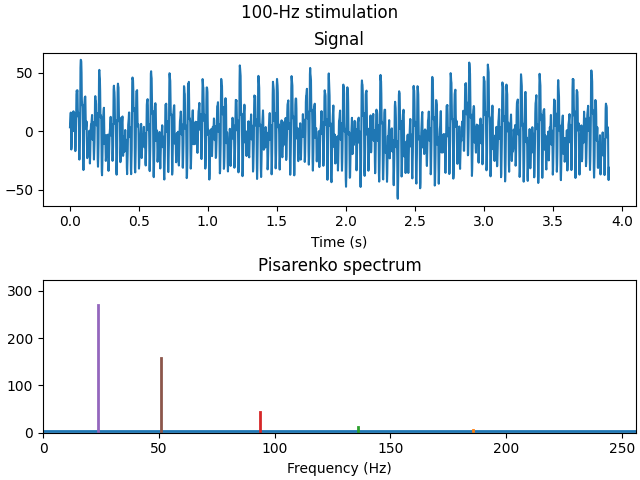

In [76]:

data=[]
for i, title in  enumerate(ttl):
   f, pp, sg2=pisarenko(eeg[:,i], 5, fs, Aff=1)
   plt.suptitle(title)
   
   data.append([title, 'frequency',"", *np.round(f,3)])
   data.append([title, 'Amplitude',"",*np.round(pp,3)])
   data.append([title, 'variance', np.round(sg2,3)]+5*[""])




In [78]:
header1=['recording', 'parameters']
header3=6*['estim.']
header2=[""]+[f'Sin. {num}' for num in np.arange(1, 6)]
multi_index = pd.MultiIndex.from_tuples(list(zip(header3, header2)))
columns = header1+multi_index.tolist()

display(pd.DataFrame(data, columns=columns).set_index(['recording','parameters']))

(estim., ) (estim., Sin. 1)  \
recording                 parameters                               
Baseline (no stimulation) frequency                      177.972   
                          Amplitude                        0.008   
                          variance        0.033                    
1-Hz stimulation          frequency                      181.141   
                          Amplitude                        0.027   
                          variance        0.061                    
100-Hz stimulation        frequency                      185.887   
                          Amplitude                        1.336   
                          variance        3.763                    

                                     (estim., Sin. 2) (estim., Sin. 3)  \
recording                 parameters                                     
Baseline (no stimulation) frequency           130.103           84.362   
                          Amplitude             0.058            0.392   
                          variance                                       
1-Hz stimulation          frequency           132.825           85.029   
                          Amplitude             0.156            1.052   
                          variance                                       
100-Hz stimulation        frequency           136.092            93.57   
                          Amplitude             7.674           39.284   
                          variance                                       

                                     (estim., Sin. 4) (estim., Sin. 5)  
recording                 parameters                                    
Baseline (no stimulation) frequency            38.888            9.023  
                          Amplitude             4.333           39.626  
                          variance                                      
1-Hz stimulation          frequency            39.609            8.726  
                          Amplitude             9.018           70.993  
                          variance                                      
100-Hz stimulation        frequency            23.537           50.792  
                          Amplitude           265.727          154.961  
                          variance

**Question 4.3.** Interpret the estimation results -- which stimulation frequency appears to effectively influence brain activity?

**Answer 4.3.** First thing we can notice is that the variance becomes higher as the frequency of stimulation also rises up. The variance between no stimulation and 1-Hz stimulation approximately double but between 1-hz and 100-Hz stimulation, the augmentation is of 60 times (approximately).  Another thing is the biggest stimulation is the sinusoid 5 at 100Hz. But as the amplitude went bigger, the frequency decreases.

The stimulation frequency which appears to effectively influence brain activity is the 100-Hz stimulation as it has the biggest variance and amplitude and we can see on the graph that the signal changes the most. The Pisanko spectrum also 